In [ ]:
!pip install pytorch_lightning
!pip install tensorboardX
!pip install faiss-gpu-cu11

In [2]:
import os
from collections import namedtuple

import pandas as pd
import numpy as np
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import tqdm
import json
import sklearn.metrics as smT

import tensorboardX as tb
import tensorflow as tf
import datetime, os
import faiss

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(31337)

2025-05-04 14:14:41.251049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746368081.275240     124 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746368081.282517     124 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Create pairs (first track, subsequent track, time)

In [3]:
data = pd.read_json(f"/kaggle/input/recsys-hw/positives.json", lines=True)

In [4]:
data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments
0,next,2025-04-15 18:17:54.456,6293,18320,1.0,0.005177,4519.0,{'PERSONALIZED': 'C'}
1,next,2025-04-15 18:17:54.461,6046,45253,1.0,0.000645,47761.0,{'PERSONALIZED': 'C'}
2,next,2025-04-15 18:17:54.461,619,43110,1.0,0.000363,43557.0,{'PERSONALIZED': 'C'}
3,next,2025-04-15 18:17:54.467,6293,4519,0.8,0.000742,15403.0,{'PERSONALIZED': 'C'}
4,next,2025-04-15 18:17:54.482,7760,15934,0.8,0.000507,14365.0,{'PERSONALIZED': 'C'}


In [5]:
Pair = namedtuple("Session", ["user", "start", "track", "time"])

def get_pairs(user_data):
    pairs = []
    first = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if first is None:
            first = row["track"]
        else:
            pairs.append(Pair(row["user"], first, row["track"], row["time"]))

        if row["message"] == "last":
            first = None
    return pairs

In [6]:
pairs = pd.DataFrame(
    data
    .groupby("user")
    .apply(get_pairs)
    .explode()
    .values
    .tolist(),
    columns=["user", "start", "track", "time"]
)

/tmp/ipykernel_124/500678007.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(get_pairs)


In [7]:
pairs.to_csv(f"preprocessed_data.csv", index=False)

In [8]:
pairs = pd.read_csv(f"/kaggle/working/preprocessed_data.csv")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


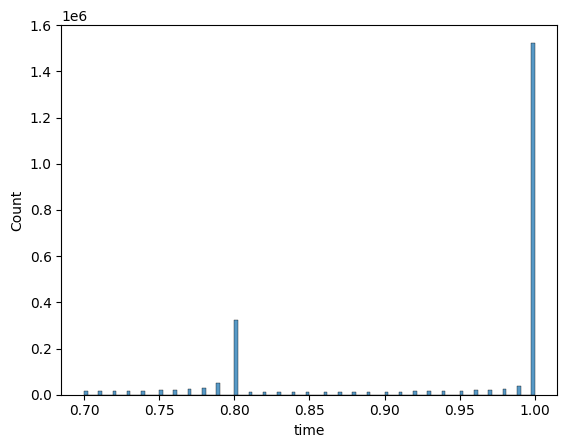

In [9]:
figure, ax = plt.subplots()
sns.histplot(pairs["time"], ax=ax)
pass

## Train Model

In [10]:
rdm = np.random.random(len(pairs))
train_data = pairs[rdm < 0.8]
val_data = pairs[(rdm >= 0.8) & (rdm < 0.9)]
test_data = pairs[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(1904048, 237309, 238460)

In [11]:
class ContextualRanker(pl.LightningModule):
    def __init__(self, embedding_dim=10):
        super().__init__()
        self.embedding_dim = embedding_dim

        # We won't have embeddings for everything, but that's ok
        self.context = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
        self.track = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)

    def forward(self, x):
        context = self.context(x[:, 0]) # start track
        track = self.track(x[:, 1]) # next track
        return torch.sum(context * track, dim=1)

    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        targets = y[:, 0].float()
        avgs = y[:, 1].float()
        rdms = y[:, 2].float()

        loss = F.mse_loss(predictions, targets, reduction='mean')
        avg_loss = F.mse_loss(avgs, targets, reduction='mean')
        rdm_loss = F.mse_loss(rdms, targets, reduction='mean')

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [12]:
class ContextualRankerData(pl.LightningDataModule):
  def __init__(self, train_data, val_data, test_data, features):
      super().__init__()
      self.train_data = train_data
      self.val_data = val_data
      self.test_data = test_data
      self.features = features

  def prepare_data(self):
      self.test_data = self.test_data.assign(rdm = np.random.random(len(self.test_data))).assign(avg = self.train_data["time"].mean())

  def setup(self, stage=None):
      if stage == "fit" or stage is None:
        self.train_dataset = td.TensorDataset(
            torch.from_numpy(self.train_data[self.features].values),
            torch.from_numpy(self.train_data["time"].values)
            )

        self.val_dataset = td.TensorDataset(
            torch.from_numpy(self.val_data[self.features].values),
            torch.from_numpy(self.val_data["time"].values)
            )

      if stage == "test" or stage is None:
        self.test_dataset = td.TensorDataset(
            torch.from_numpy(self.test_data[self.features].values),
            torch.from_numpy(self.test_data[["time", "avg", "rdm"]].values)
        )
  def train_dataloader(self):
      return td.DataLoader(self.train_dataset, batch_size=4096, shuffle=True, num_workers=0)

  def val_dataloader(self):
      return td.DataLoader(self.val_dataset, batch_size=4096, num_workers=0)

  def test_dataloader(self):
      return td.DataLoader(self.test_dataset, batch_size=4096, shuffle=False, num_workers=0)

In [13]:
net = ContextualRanker(embedding_dim=400)
data_module = ContextualRankerData(train_data, val_data, test_data, features = ["start", "track"])

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=400,
    accelerator='cuda',
    devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ], enable_progress_bar=True)

In [ ]:
trainer.fit(
    net,
    data_module
)

In [ ]:
shutil.copy(checkpoint_callback.best_model_path, f"contextual_ranker.ckpt")

In [18]:
best = ContextualRanker.load_from_checkpoint(f"/kaggle/input/recsys-hw/results (5)/contextual_ranker.ckpt", embedding_dim=400)

In [19]:
trainer.test(best, data_module)

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         avg_loss          │   0.008809637278318405    │
│         rdm_loss          │    0.28410616517066956    │
│         test_loss         │    0.03869606554508209    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.03869606554508209,
  'avg_loss': 0.008809637278318405,
  'rdm_loss': 0.28410616517066956}]

## Compute top recommendations

In [20]:
track_meta = pd.read_json(f"/kaggle/input/recsys-hw/tracks.json", lines=True)

In [21]:
context_embeddings = dict(best.named_parameters())["context.weight"].data.cpu().numpy()
track_embeddings = dict(best.named_parameters())["track.weight"].data.cpu().numpy()

In [22]:
track_meta.head()

,artist,album,title,genre,pop,duration,track
0,Михаил Бублик,ART-Обстрел I-часть,Сорок тысяч верст,"[1, 47]",-0.500252,282,41164
1,Xamdam Sobirov,Baxtli Bo'lolmadik,Baxtli Bo'lolmadik,[1],-0.942953,205,27544
2,Сергей Какенов,Ишимская шпана,Крутые лагеря,[147],-0.801382,252,34702
3,Loc-Dog,Electrodog 2,Еду убивать,[17],-0.577525,276,45907
4,Gafur,Февраль,Февраль,[1],-0.738636,160,14978


In [23]:
index = faiss.index_factory(track_embeddings.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)

In [24]:
index.add(track_embeddings.astype('float32'))

In [ ]:
k = 100
with open(f"recommendations_contextual.json", "w") as rf:
    for _, track in tqdm.tqdm(track_meta.iterrows(), total=len(track_meta)):
        embedding = context_embeddings[track["track"]]
        dists, neighbours = index.search(embedding.astype('float32')[np.newaxis, :], k)
        #neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
        recommendation = dict(track)
        recommendation["recommendations"] = neighbours.flatten().tolist()

        rf.write(json.dumps(recommendation, ensure_ascii=False) + "\n")